In [1]:
import os
import gc
import h5py
import pandas as pd
import numpy as np

import sklearn.metrics as metrics

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
import seaborn as sns

import sys
sys.path.append("../")
import utils_plot

In [2]:
cm = 1/2.54 
plot_alpha=0.2
h=5.8
w=6

resp_res_path = "/cluster/work/grlab/clinical/hirid2/research/event_based_analysis/resp/"
resp_fig_path = "paper_figures_resp"
if not os.path.exists(resp_fig_path):
    os.mkdir(resp_fig_path)

In [3]:
def read_event_based_pr_single_split(res_path, 
                                     pred_win=1440, 
                                     min_event_gap=0, 
                                     t_silence=30,
                                     t_buffer=0,
                                     t_reset=30,
                                     calibration_scaler=1,
                                     random_classifier=False):
    """
    res_path: path to the event-based evaluation results
    pred_win: future prediction window size (in minutes)
    min_event_gap: the minimal event gap length (in minutes), any gap smaller should be closed
    t_silence: alarm silencing time (in minutes)
    t_buffer: minimal buffer time before event
    t_reset: alarm reset time after patient recovers from failure event
    calibration_scaler: scaler to calibrate the prevalence (AUPRC of the random classifier)
    """
    
    prefix_str = "tg-%d_tr-%d_dt-%d_ws-%d_ts-%d"%(min_event_gap,
                                                  t_reset,
                                                  t_buffer,
                                                  pred_win,
                                                  t_silence) # prefix for different configuration
    res = []
    for f in os.listdir(res_path):
        if prefix_str+"_" in f or prefix_str+"." in f:
            if random_classifier and "rand" in f:
                res.append(pd.read_csv(os.path.join(res_path,f)))
            elif not random_classifier and "rand" not in f:
                res.append(pd.read_csv(os.path.join(res_path,f)))     
    try:            
        res = pd.concat(res)
    except:
        raise Exception("%s"%res_path)
    res.loc[:,"FA"] = calibration_scaler * res.FA # calibrate the false alarms using the scale
    
    res.loc[:,"recall"] = res.CE / (res.CE+res.ME)
    res.loc[:,"precision"] = res.TA / (res.TA+res.FA)
    res = res.sort_values(["tau", "recall", "precision"])
    res = res.drop_duplicates("recall", keep="last")
    res = res.reset_index(drop=True)
    return res

def read_event_based_pr_multi_splits(res_path, 
                                     splits,
                                     pred_win=1440, 
                                     min_event_gap=0, 
                                     t_silence=30,
                                     t_buffer=0,
                                     t_reset=30,
                                     calibration_scaler=1,
                                     random_classifier=False):
    """
    res_path: path to the event-based evaluation results
    splits: list of splits 
    pred_win: future prediction window size (in minutes)
    min_event_gap: the minimal event gap length (in minutes), any gap smaller should be closed
    t_silence: alarm silencing time (in minutes)
    t_buffer: minimal buffer time before event
    t_reset: alarm reset time after patient recovers from failure event
    calibration_scaler: scaler to calibrate the prevalence (AUPRC of the random classifier)
    """
    if type(splits) is not list and type(split)==str:
        splits = [splits]
        
    res = dict()
    for split in splits:
        res.update({split: read_event_based_pr_single_split(os.path.join(res_path, split),
                                                             pred_win=pred_win,
                                                             min_event_gap=min_event_gap,
                                                             t_silence=t_silence,
                                                             t_buffer=t_buffer,
                                                             t_reset=t_reset,
                                                             random_classifier=random_classifier,
                                                             calibration_scaler=calibration_scaler)})
        
    return res


def plot_event_based_prc(curves, fixed_rec=0.8):
    """
    curves: a dictionary containing the configuration of all curves in the same plot
    """
    dict_res = dict()
    for i, model in enumerate(curves.keys()):
        if "calibration_scaler" in curves[model]:
            calibration_scaler = curves[model]["calibration_scaler"]
        else:
            calibration_scaler = 1
        res = read_event_based_pr_multi_splits(curves[model]["res_path"], 
                                               curves[model]["splits"], 
                                               pred_win=curves[model]["pred_win"],
                                                 min_event_gap=curves[model]["min_event_gap"],
                                                 t_silence=curves[model]["t_silence"],
                                                 t_buffer=curves[model]["t_buffer"],
                                                 t_reset=curves[model]["t_reset"],
                                                 random_classifier=curves[model]["random_classifier"],
                                                 calibration_scaler=calibration_scaler)
        aggr_res = [] # aggregated results from all splits
        for k, v in res.items():
            aggr_res.append(v.set_index("recall").sort_index().rename(columns={"precision":k})[[k]])
            
        
        aggr_res = pd.concat(aggr_res, axis=1)
        aggr_res = aggr_res.sort_index()
        aggr_res = aggr_res.interpolate(method="index")
        aggr_res = aggr_res[aggr_res.isnull().sum(axis=1)==0]
        
        dict_res.update({model:aggr_res})
        
        if "single_point" in curves[model] and curves[model]["single_point"]:
            
            aggr_res =  aggr_res[aggr_res.index<1]
            precision_mean = aggr_res.mean(axis=1)
            precision_std = aggr_res.std(axis=1) if aggr_res.shape[1]>1 else 0
            
            plt.errorbar(aggr_res.index,
                         precision_mean,
                         yerr=precision_std,
                         color=curves[model]["color"],
                         marker=curves[model]["marker_style"],
                         label=model)
            
        else:
            aucs = [metrics.auc(aggr_res.index,aggr_res[k]) for k in aggr_res.columns]

            precision_mean = aggr_res.mean(axis=1)
            precision_std = aggr_res.std(axis=1)

            esti_rec = aggr_res.index[np.argmin(np.abs(aggr_res.index-fixed_rec))]
            
            plt.plot(aggr_res.index, 
                     precision_mean,
                     color=curves[model]["color"],
                     linestyle=curves[model]["linestyle"],
                     label=model)
            plt.fill_between(aggr_res.index,
                             precision_mean-precision_std,
                             precision_mean+precision_std,
                             color=curves[model]["color"],
                             alpha=plot_alpha)
            
            scale = 0.06
            if np.std(aucs)==0:
                plt.text(0.03, 
                         scale*(len(curves)-i), 
                         "%3.3f (prec@rec=%3.1f%%:%3.1f%%)"%(np.mean(aucs), esti_rec*100, precision_mean.loc[esti_rec]*100),
                         color=curves[model]["color"])
                # plt.text(0.03, 
                #          scale*(len(curves)-i), 
                #          "%3.3f"%np.mean(aucs),
                #          color=curves[model]["color"])
                
            else:
                # plt.text(0.03, 
                #          scale*(len(curves)-i), 
                #          "%3.3f$\pm$%3.3f"%(np.mean(aucs), np.std(aucs)),
                #          color=curves[model]["color"])
                plt.text(0.03, 
                         scale*(len(curves)-i), 
                         "%3.3f$\pm$%3.3f (prec@rec=%3.1f%%:%3.1f%%)"%(np.mean(aucs), np.std(aucs), esti_rec*100, precision_mean.loc[esti_rec]*100),
                         color=curves[model]["color"])
            
    plt.text(0.03, 
             scale*(len(curves)+1), 
             "AUPRC")
    plt.grid(alpha=0.2)    
    plt.axis("equal")
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.legend(loc=1, facecolor="white")
    plt.xlabel("Event Recall")
    plt.ylabel("Precision")
    return dict_res

    
def plot_cumulative_recall(datapath, res_dir, configs, tbins, endpoint_name=None, lst_rec=[0.9], lst_prec=None, errorbar=False, resp_fig_path=None, RANDOM=False):
    key_split = "temporal_1"
    lst_split = [] 
    if errorbar:
        lst_split += ["temporal_%d"%i for i in np.arange(1,6)]
    dict_recall = dict()
    dict_farate = dict()
    dict_prec = dict()
    
    lst_val = lst_rec if lst_prec is None else lst_prec

    for tsplit in lst_split:
        dict_recall.update({tsplit:dict()})
        dict_farate.update({tsplit:dict()})
        dict_prec.update({tsplit:dict()})
        df = utils_plot.get_df(datapath, res_dir, tsplit, configs)
        for n, fixed_metric in enumerate(lst_val):
            if lst_prec is None:
                rec_bins, fa_rate_e, fa_rate_n = utils_plot.get_alarm(datapath, res_dir, tsplit, configs, tbins, fixed_rec=fixed_metric, RANDOM=RANDOM)
                dict_recall[tsplit].update({fixed_metric:rec_bins})
                dict_farate[tsplit].update({fixed_metric:fa_rate_e})
                dict_prec[tsplit].update({fixed_metric: df.iloc[np.argmin(np.abs(df.rec.values-fixed_metric))].prec})
            else:
                rec_bins, fa_rate_e, fa_rate_n = utils_plot.get_alarm(datapath, res_dir, tsplit, configs, tbins, fixed_prec=fixed_metric, RANDOM=RANDOM)
                dict_recall[tsplit].update({fixed_metric:rec_bins})
                dict_farate[tsplit].update({fixed_metric:fa_rate_e})
                dict_prec[tsplit].update({fixed_metric: df.iloc[np.argmin(np.abs(df.prec.values-fixed_metric))].prec})
                
            gc.collect()

    plt.figure(figsize=(w*cm,h*cm))
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_yticks([],[])
    ax.set_xlabel("Alarm time before event - $\\mathbf{t}$ (h)")
    ax = ax.twinx()
    cmaps = sns.color_palette("tab20c")[4:7][::-1]
    # cmaps = ["C9", "C0", "C6"]
    markers = ["d", "*", "."]
    # markers = [".", ".", "."]
    
    for i, key in enumerate(lst_val):
        # rec_bins = dict_recall[key_split][key]
        rec_bins = np.mean([dict_recall[tsplit][key] for tsplit in lst_split[1:]], axis=0)
        print(rec_bins)
        prec = dict_prec[key_split][key]
        
        if errorbar:
            rec_bins_std = np.std([dict_recall[tsplit][key] for tsplit in lst_split[1:]], axis=0)
            prec_std = np.std([dict_prec[tsplit][key] for tsplit in lst_split[1:]])
            rec_std = np.std([dict_recall[tsplit][key][0] for tsplit in lst_split[1:]])

            plt.fill_between(-tbins[::-1]-np.diff(tbins)[0]/2, 
                             rec_bins[::-1]-rec_bins_std[::-1], 
                             rec_bins[::-1]+rec_bins_std[::-1], alpha=0.2, 
                             label="_nolegend_", 
                             color=cmaps[i])
            
        if lst_prec is None:
            plt.plot(-tbins[::-1]-np.diff(tbins)[0]/2, 
                     rec_bins[::-1], 
                     marker=markers[i],
                     markersize=4,
                     label="Rec=%0.2f, prec=%0.2f"%(key,prec)+("$\pm$%0.2f"%prec_std if errorbar else ""),
                     color=cmaps[i])
        else:
            plt.plot(-tbins[::-1]-np.diff(tbins)[0]/2, 
                     rec_bins[::-1], 
                     marker=markers[i],
                     markersize=4,
                     label="prec=%0.2f, rec=%0.2f"%(key,rec_bins[0])+("$\pm$%0.2f"%rec_std if errorbar else ""),
                     color=cmaps[i])
            xvals = -tbins[::-1]-np.diff(tbins)[0]/2
            yvals = rec_bins[::-1]
            print(key, [(xvals[i], yvals[i]) for i in range(len(xvals))])

            
    plt.axvline(0, color="C3", linestyle="--")
    plt.axvline(-24, color="C7", linestyle="--")
    plt.legend(loc=4)
    # plt.ylim([0.3,1.05])

    xleft = plt.xlim()[0]
    xright = plt.xlim()[1]
    xscale = ( xright - xleft ) / 10
    if endpoint_name is not None:
        plt.text(xright-5.5*xscale, 1, endpoint_name, horizontalalignment="left", color="C3", fontweight="bold")
    plt.arrow(xright-5*xscale+3.5*xscale, 1.01, 0.8*xscale, 0, color="C3", width=0.003*xscale, head_width=0.006*xscale,head_length=0.1*xscale, zorder=10)

    
    ax.set_ylabel("Recall rate by alarms at $\\mathbf{t}$ h before event")
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    
    d = .4  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color="k", mec="k", mew=1, clip_on=False)
    ax.plot([1, 1], [0.08, 0.06], transform=ax.transAxes, **kwargs)
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color="w", mec="w", mew=5, clip_on=False, zorder=11)
    ax.plot([1], [0.07], transform=ax.transAxes, **kwargs)

    plt.xticks(-tbins[::-2],tbins[::-2])
    # plt.yticks(np.arange(0.3, 1.1, 0.1), ["%0.1f"%x for x in [0.0]+np.arange(0.4, 1.1, 0.1).tolist()])
    plt.grid(axis="y")
    plt.xlim([-tbins[-1],0])
    plt.tight_layout()
    if resp_fig_path is not None:
        plt.savefig(resp_fig_path)
    plt.show()
    

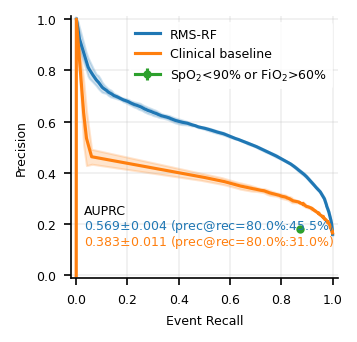

In [4]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"RMS-RF": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_compact_all"),
                               color="C0",
                               linestyle="-",
                               random_classifier=False,
                               splits=splits)})

curves.update({"Clinical baseline": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_clinical_baseline_tree_all"),
                                         color="C1",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

curves.update({"SpO$_2$<90% or FiO$_2$>60%": dict(res_path=os.path.join(resp_res_path,"WorseFromZeroOrOne_clinical_baseline_spo2_fio2_all"),
                                                  color="C2",
                                                  marker_style=".",
                                                  random_classifier=False,
                                                  single_point=True,
                                                  splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig1"))
plt.show()

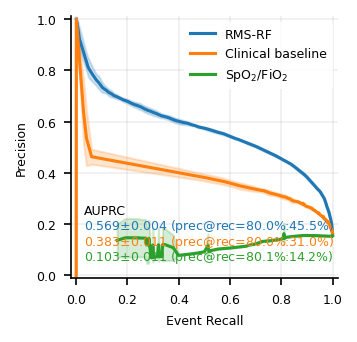

In [5]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"RMS-RF": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_compact_all"),
                               color="C0",
                               linestyle="-",
                               random_classifier=False,
                               splits=splits)})

curves.update({"Clinical baseline": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_clinical_baseline_tree_all"),
                                         color="C1",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

curves.update({"SpO$_2$/FiO$_2$": dict(res_path=os.path.join(resp_res_path,"WorseFromZeroOrOne_clinical_baseline_spo2_fio2_continuous_impute_all"),
                                                  color="C2",
                                                  linestyle="-",
                                                  random_classifier=False,
                                                  splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig1_spo2_fio2"))
plt.show()

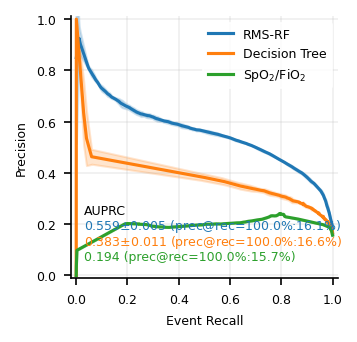

In [6]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"RMS-RF": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_rmsRF_all"),
                               color="C0",
                               linestyle="-",
                               random_classifier=False,
                               splits=splits)})

curves.update({"Decision Tree": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_clinical_baseline_tree_all"),
                                         color="C1",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

curves.update({"SpO$_2$/FiO$_2$": dict(res_path=os.path.join(resp_res_path,"WorseFromZeroOrOne_clinical_baseline_fio2_spo2_continuous_impute_all"),
                                                  color="C2",
                                                  linestyle="-",
                                                  random_classifier=False,
                                                  splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves, fixed_rec=1.0)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig1_fio2_spo2"))
plt.show()

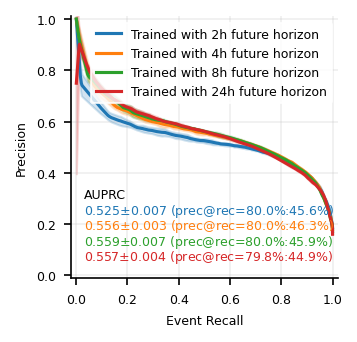

In [7]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"Trained with 2h future horizon": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_rmsRF_new_2hr_all"),
                               color="C0",
                               linestyle="-",
                               random_classifier=False,
                               splits=splits)})

curves.update({"Trained with 4h future horizon": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_rmsRF_new_4hr_all"),
                                         color="C1",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

curves.update({"Trained with 8h future horizon": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_rmsRF_new_8hr_all"),
                                         color="C2",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

curves.update({"Trained with 24h future horizon": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_rmsRF_new_24hr_all"),
                                         color="C3",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_horizon_change"))
plt.show()

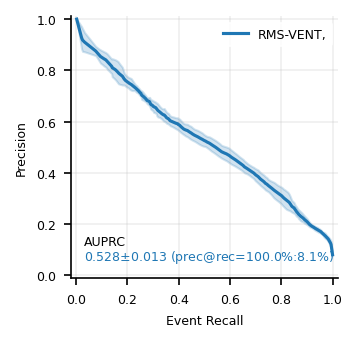

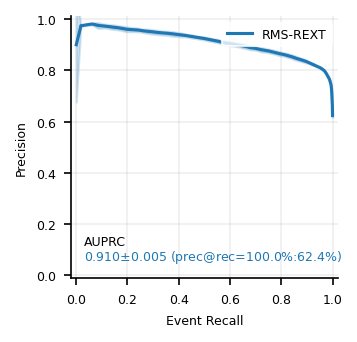

In [8]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"RMS-VENT,": dict(res_path=os.path.join(resp_res_path, "Ventilation_rmsVent_internal_all"),
                               color="C0",
                               linestyle="-",
                               random_classifier=False,
                               splits=splits)})


for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves, fixed_rec=1.0)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_vent"))
plt.show()


# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

curves = dict()
curves.update({"RMS-REXT": dict(res_path=os.path.join(resp_res_path, "ReadyExtubate24_rmsREXP_internal_all"),
                                         color="C0",
                                         linestyle="-",
                                         random_classifier=False,
                                         splits=splits)})

for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))

plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves, fixed_rec=1.0)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_rext"))
plt.show()


In [ ]:
resp_ews_configs = dict()
resp_ews_configs.update(t_mingap_m=0)
resp_ews_configs.update(t_reset_m=30)
resp_ews_configs.update(t_delta_m=0)
resp_ews_configs.update(t_window_m=1440)
resp_ews_configs.update(t_window_h=24)
resp_ews_configs.update(t_silence_m=240)

plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_internal_rmsRF_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       lst_rec=[0.95,0.9,0.8],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2") )

0.95 1708 1797
1708.0 1797.0


/cluster/home/xlyu/projects2016-ICUscore/analyses/event_based/notebooks/utils_plot.py:400: RuntimeWarning: invalid value encountered in true_divide
  rec_bins = ce_bins / (ce_bins+me_bins)


0.9 1611 1797
1611.0 1797.0


/cluster/home/xlyu/projects2016-ICUscore/analyses/event_based/notebooks/utils_plot.py:400: RuntimeWarning: invalid value encountered in true_divide
  rec_bins = ce_bins / (ce_bins+me_bins)


In [ ]:
resp_ews_configs = dict()
resp_ews_configs.update(t_mingap_m=0)
resp_ews_configs.update(t_reset_m=30)
resp_ews_configs.update(t_delta_m=0)
resp_ews_configs.update(t_window_m=1440)
resp_ews_configs.update(t_window_h=24)
resp_ews_configs.update(t_silence_m=240)

plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_rmsRF_new_24hr_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       # lst_rec=[0.95,0.9,0.8],
                       lst_prec=[0.3,0.4,0.45],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2_24hr") )


plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_rmsRF_new_8hr_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       lst_prec=[0.3,0.4,0.45],
                       # lst_rec=[0.95,0.9,0.8],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2_8hr") )

plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_rmsRF_new_4hr_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       lst_prec=[0.3,0.4,0.45],
                       # lst_rec=[0.95,0.9,0.8],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2_4hr") )

plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_rmsRF_new_2hr_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       lst_prec=[0.3,0.4,0.45],
                       # lst_rec=[0.95,0.9,0.8],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2_2hr") )

In [ ]:
plot_cumulative_recall(resp_res_path,
                       "WorseFromZeroOrOne_rmsRF_new_2hr_all", 
                       resp_ews_configs,
                       np.arange(0,49,2),
                       errorbar=True,
                       lst_prec=[0.3,0.4,0.45],
                       # lst_rec=[0.95,0.9,0.8],
                       endpoint_name="Respiratory failure",
                       resp_fig_path=os.path.join(resp_fig_path, "fig2_subfig2_2hr") )

In [ ]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

prev_db1 = 0.151
prev_db2 = 0.219
calibrated_s = (1/prev_db1-1) / (1/prev_db2-1)

curves = dict()
curves.update({"HiRID    -> HiRID": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_var20_all"),
                                      color="C9",
                                      linestyle="-",
                                      random_classifier=False,
                                      splits=splits)})

# curves.update({"HiRID    -> HiRID (w/o drugs)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_compact_drop_pharma_all"),
#                                       color="C9",
#                                       linestyle="-",
#                                       random_classifier=False,
#                                       splits=splits)})

curves.update({"HiRID    -> UMCDB": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_val_umc_20var_all_rerun"),
                                                   color="C1",
                                                   linestyle="-",
                                                   random_classifier=False,
                                                   calibration_scaler=calibrated_s,
                                                   splits=splits)})

splits = ["%d"%i for i in np.arange(1,6)]
curves.update({"HiRID    -> UMCDB (transport)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_val_transported_20vars_v2_all"),
                                      color="C7",
                                      linestyle="-",
                                      random_classifier=False,
                                      calibration_scaler=calibrated_s,
                                      splits=splits)})

# curves.update({"HiRID    -> UMCDB (w/o drugs)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_second_retry_old_umc_val_no_pharma_all_rerun"),
#                                                    color="C1",
#                                                    linestyle="-",
#                                                    random_classifier=False,
#                                                    calibration_scaler=calibrated_s,
#                                                    splits=splits)})

splits = ["random_%d"%i for i in np.arange(1,6)]
curves.update({"UMCDB -> UMCDB": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_retrain_rmsRF_pharma_all"),
                                      color="C8",
                                      linestyle="-",
                                      random_classifier=False,
                                      calibration_scaler=calibrated_s,
                                      splits=splits)})



# curves.update({"UMCDB -> UMCDB (w/o drugs)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_retrain_compact_drop_pharma_all_rerun"),
#                                       color="C8",
#                                       linestyle="-",
#                                       random_classifier=False,
#                                       calibration_scaler=calibrated_s,
#                                       splits=splits)})



for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))
    
plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
plt.legend(title="   RMS-RF-p")
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig5_v2"))
plt.show()

In [ ]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

prev_db1 = 0.151
prev_db2 = 0.219
calibrated_s = (1/prev_db1-1) / (1/prev_db2-1)

curves = dict()

curves.update({"HiRID->HiRID": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_rmsRF_all"),
                                      color="C0",
                                      linestyle="-",
                                      random_classifier=False,
                                      splits=splits)})

curves.update({"HiRID->UMCDB": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_val_rmsRF_all"),
                                                   color="C3",
                                                   linestyle="-",
                                                   random_classifier=False,
                                                   calibration_scaler=calibrated_s,
                                                   splits=splits)})

splits = ["random_%d"%i for i in np.arange(1,6)]
curves.update({"UMCDB->UMCDB": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_retrain_rmsRF_all"),
                                                  color="C4",
                                                  linestyle="-",
                                                  random_classifier=False,
                                                  calibration_scaler=calibrated_s,
                                                  splits=splits)})



for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))
    
plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
plt.legend(title="   RMS-RF")
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig5"))
plt.show()

In [ ]:
# metric = "Precision @ Recall=80%"
metric = "AUPRC"

# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]

prev_db1 = 0.151
prev_db2 = 0.219
calibrated_s = (1/prev_db1-1) / (1/prev_db2-1)

curves_hirid = dict()

for i, training_size in enumerate([1,2,5,10,25,50]):
    curves_hirid.update({"training size = %d%%"%training_size: dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_training_size_%dpct_all"%training_size),
                                                         color="C%d"%i,
                                                         linestyle="-",
                                                         random_classifier=False,
                                                         training_size=training_size,
                                                         splits=splits)})

curves_hirid.update({"training size = 100%": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_rmsRF_all"),
                                                     color="C%d"%i,
                                                     linestyle="-",
                                                     random_classifier=False,
                                                     training_size=100,
                                                     splits=splits)})



for k in curves_hirid.keys():
    curves_hirid[k].update(dict(**resp_ews_configs))    
    

plt.figure(figsize=(w*1.5*cm, h*cm))
xticks_hirid, auprc_hirid = plot_metric_vs_setting(curves_hirid, ylabel="auprc", xlabel="training_size", fixed_rec=0.8, color='C3')
plt.ylabel("AUPRC", color='C3')
plt.xlabel('Training set size [%]')
ax1 = plt.gca()
ax1.spines[['right']].set_visible(True)
ax1.tick_params(axis='y', labelcolor='C3')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
xticks_hirid, auprc_hirid = plot_metric_vs_setting(curves_hirid, ylabel="precision", xlabel="training_size", fixed_rec=0.8, color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
ax2.spines[['right']].set_visible(True)
plt.ylabel("Precision @ 80% Recall", color='C0')
plt.xlabel('Training set size [%]')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"extended_fig3e"))
plt.show()

In [ ]:
# early warning system configuration
resp_ews_configs = dict()
resp_ews_configs.update(pred_win=1440)
resp_ews_configs.update(min_event_gap=0)
resp_ews_configs.update(t_silence=240)
resp_ews_configs.update(t_buffer=0)
resp_ews_configs.update(t_reset=30)
splits = ["temporal_%d"%i for i in np.arange(1,6)]


prev_db1 = 0.151
prev_db2 = 0.219
calibrated_s = (1/prev_db1-1) / (1/prev_db2-1)


curves = dict()
curves.update({"HiRID    -> HiRID": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_compact_all"),
                                     color="C0",
                                     linestyle="-",
                                     random_classifier=False,
                                     splits=splits)})

curves.update({"HiRID    -> HiRID\n(compact size)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_internal_umc_compactsize_all"),
                                     color="C9",
                                     linestyle="-",
                                     random_classifier=False,
                                     splits=splits)})

curves.update({"HiRID    -> UMCDB\n(w/o pharma)": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_second_retry_old_umc_val_no_pharma_all_rerun"),
                                         color="C1",
                                         linestyle="-",
                                         random_classifier=False,
                                         calibration_scaler=calibrated_s,
                                         splits=splits)})

splits = ["random_%d"%i for i in np.arange(1,6)]
curves.update({"UMCDB -> UMCDB": dict(res_path=os.path.join(resp_res_path, "WorseFromZeroOrOne_second_retry_old_umc_retrain_all_rerun"),
                                      color="C2",
                                      linestyle="-",
                                      random_classifier=False,
                                      calibration_scaler=calibrated_s,
                                      splits=splits)})


for k in curves.keys():
    curves[k].update(dict(**resp_ews_configs))
    
plt.figure(figsize=(w*cm, h*cm))
dict_res = plot_event_based_prc(curves)
# plt.title("UMC", fontsize=6)
plt.tight_layout()
plt.savefig(os.path.join(resp_fig_path,"fig2_subfig7"))
plt.show()